XAI Comparison: Grad-CAM vs LIME

Setup & Imports

In [1]:
# System
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# PyTorch & Vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image

# Pretrained model
import timm

# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# LIME
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Dataset / Metrics
import pandas as pd

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load the Saved ViT Model

In [2]:
# Rebuild model architecture
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, 2)

# Load weights (strip 'module.' if you saved under DataParallel)
state = torch.load('models/vit_ai_detection_10.pth', map_location=device, weights_only=True)
new_state = {k.replace('module.',''):v for k,v in state.items()}
model.load_state_dict(new_state)

model = model.to(device)
model.eval()
print("Model loaded.")

Model loaded.


Prepare Training Dataset & Sample Indices

In [3]:
# Define the same transform as used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset class that also returns labels
class TrainImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        df = pd.read_csv(csv_file)
        df['file_name'] = df['file_name'].apply(lambda x: os.path.join(root_dir, x))
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['file_name']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label

train_dataset = TrainImageDataset('datasets/train.csv', 'datasets', transform=transform)

# Sample 3 real (0) and 3 AI (1)
real_idxs = train_dataset.df[train_dataset.df['label']==0].index.tolist()
ai_idxs   = train_dataset.df[train_dataset.df['label']==1].index.tolist()
train_example_indices = random.sample(real_idxs, 3) + random.sample(ai_idxs, 3)
train_first_idx = train_example_indices[0]
print("Train examples (3 real + 3 AI):", train_example_indices)
print("First train example index:", train_first_idx)

Train examples (3 real + 3 AI): [14593, 3279, 36049, 32098, 29256, 18288]
First train example index: 14593


Prepare Test Dataset

In [4]:
# Define the exact same transform used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class TestImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        df = pd.read_csv(csv_file)
        # detect which column holds the path
        if 'file_name' in df.columns:
            df['relpath'] = df['file_name']
        elif 'id' in df.columns:
            df['relpath'] = df['id']
        else:
            raise KeyError("CSV must have 'file_name' or 'id' column")
        self.df = df
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel = self.df.iloc[idx]['relpath']
        path = os.path.join(self.root, rel)
        img  = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

test_dataset = TestImageDataset('datasets/test.csv', 'datasets', transform=transform)

# pick one image for XAI
image_tensor = test_dataset[0]               # C×H×W tensor
rgb_np       = image_tensor.permute(1,2,0).cpu().numpy()
rgb_vis      = (rgb_np*0.5 + 0.5).clip(0,1)   # for visualization

# pick the six indices you want to explain
example_indices = [0, 1, 2, 3, 4, 5]

Predict Label for That Image

In [5]:
with torch.no_grad():
    logits = model(image_tensor.unsqueeze(0).to(device))
pred_label = logits.argmax(dim=1).item()
print(f"Model prediction (0=Real,1=AI-Gen): {pred_label}")
true_label = pred_label  # use predicted label as target for explanations

Model prediction (0=Real,1=AI-Gen): 0


Grad-CAM Explanation

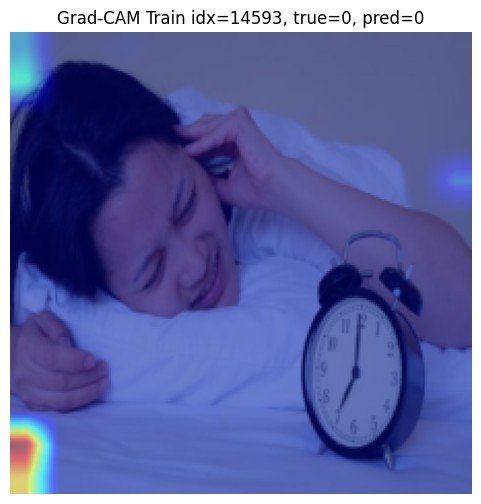

In [6]:
# Define reshape_transform to convert ViT outputs into 2D feature maps
def reshape_transform(tensor, height=14, width=14):
    # Remove class token, reshape to [B, H, W, D]
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    # Permute to [B, D, H, W]
    return result.permute(0, 3, 1, 2)

# Unwrap DataParallel if used
base_model = model.module if isinstance(model, nn.DataParallel) else model

# Choose the last block's LayerNorm as target
target_layers = [base_model.blocks[-1].norm1]

# Initialize GradCAM (no use_cuda argument)
cam = GradCAM(
    model=base_model,
    target_layers=target_layers,
    reshape_transform=reshape_transform
)

# use the same first_idx
image_tensor, true_label = train_dataset[train_first_idx]
rgb_np = image_tensor.permute(1,2,0).cpu().numpy()
rgb_vis = (rgb_np * 0.5 + 0.5).clip(0,1)

# get model prediction
with torch.no_grad():
    pred_label = model(image_tensor.unsqueeze(0).to(device)).argmax(1).item()

# Compute Grad-CAM heatmap
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0).to(device), targets=[ClassifierOutputTarget(true_label)])[0]

# Overlay on the original image
cam_vis = show_cam_on_image(rgb_vis, grayscale_cam, use_rgb=True)

# Display
plt.figure(figsize=(6,6))
plt.imshow(cam_vis)
plt.title(f"Grad-CAM Train idx={train_first_idx}, true={true_label}, pred={pred_label}")
plt.axis('off')
plt.show()

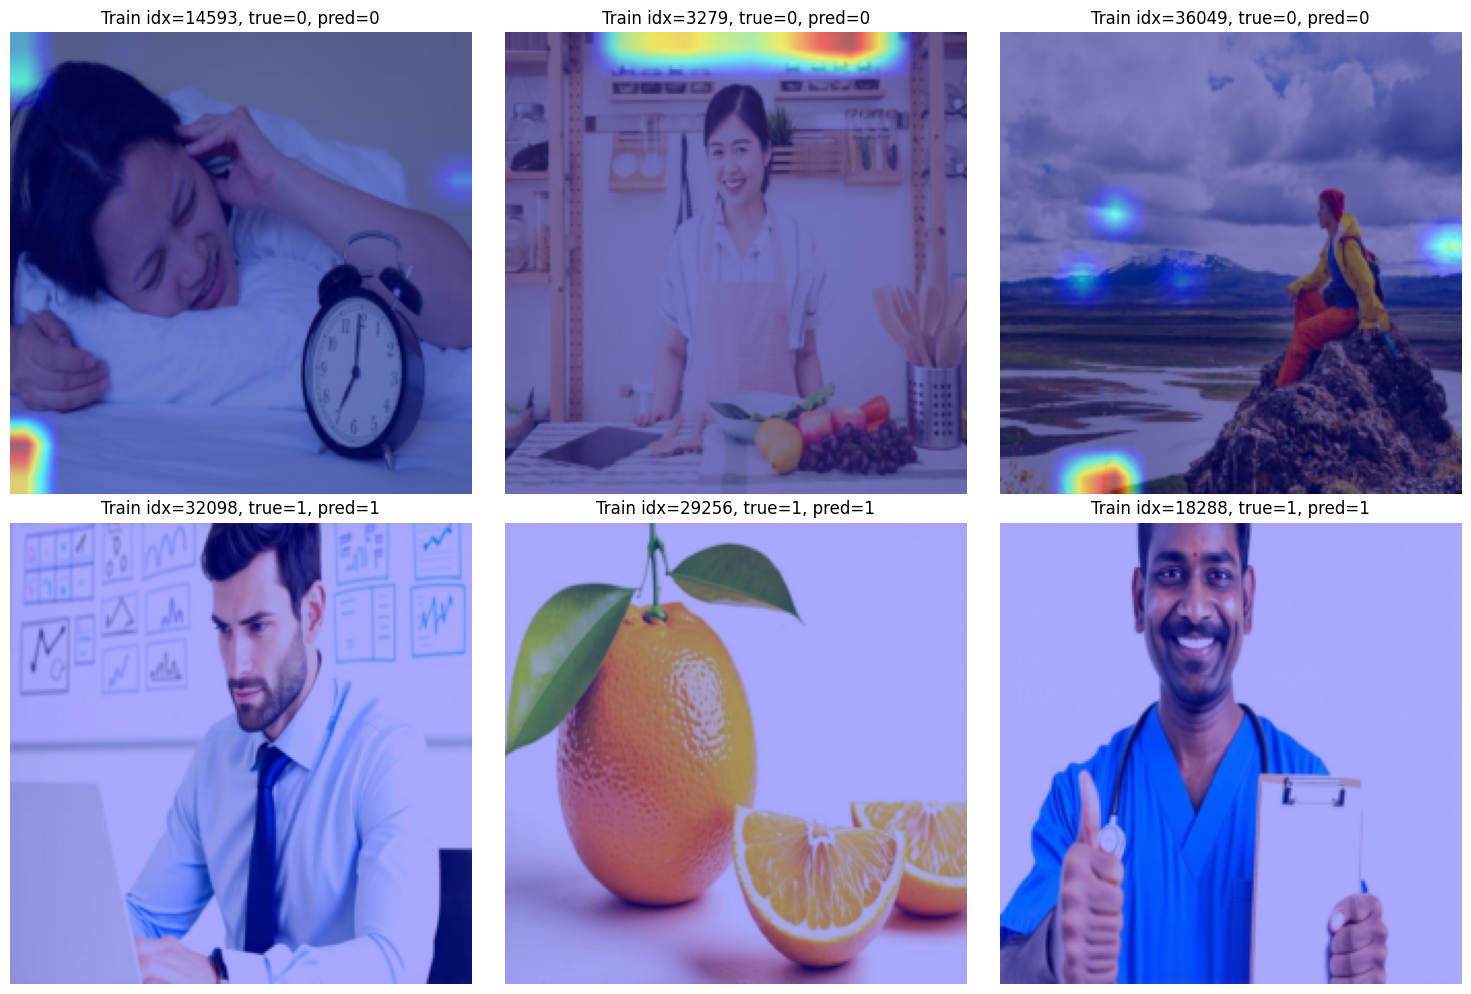

In [7]:
# Six Training Examples: Grad-CAM
fig, axes = plt.subplots(2, 3, figsize=(15,10))

for ax, idx in zip(axes.flatten(), train_example_indices):
    img_t, true_label = train_dataset[idx]
    rgb_np  = img_t.permute(1,2,0).cpu().numpy()
    rgb_vis = (rgb_np * 0.5 + 0.5).clip(0,1)

    # model prediction
    with torch.no_grad():
        pred_label = model(img_t.unsqueeze(0).to(device)).argmax(1).item()

    # Grad-CAM on true label
    heatmap = cam(
        input_tensor=img_t.unsqueeze(0).to(device),
        targets=[ClassifierOutputTarget(true_label)]
    )[0]
    cam_img = show_cam_on_image(rgb_vis, heatmap, use_rgb=True)

    ax.imshow(cam_img)
    ax.set_title(f"Train idx={idx}, true={true_label}, pred={pred_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

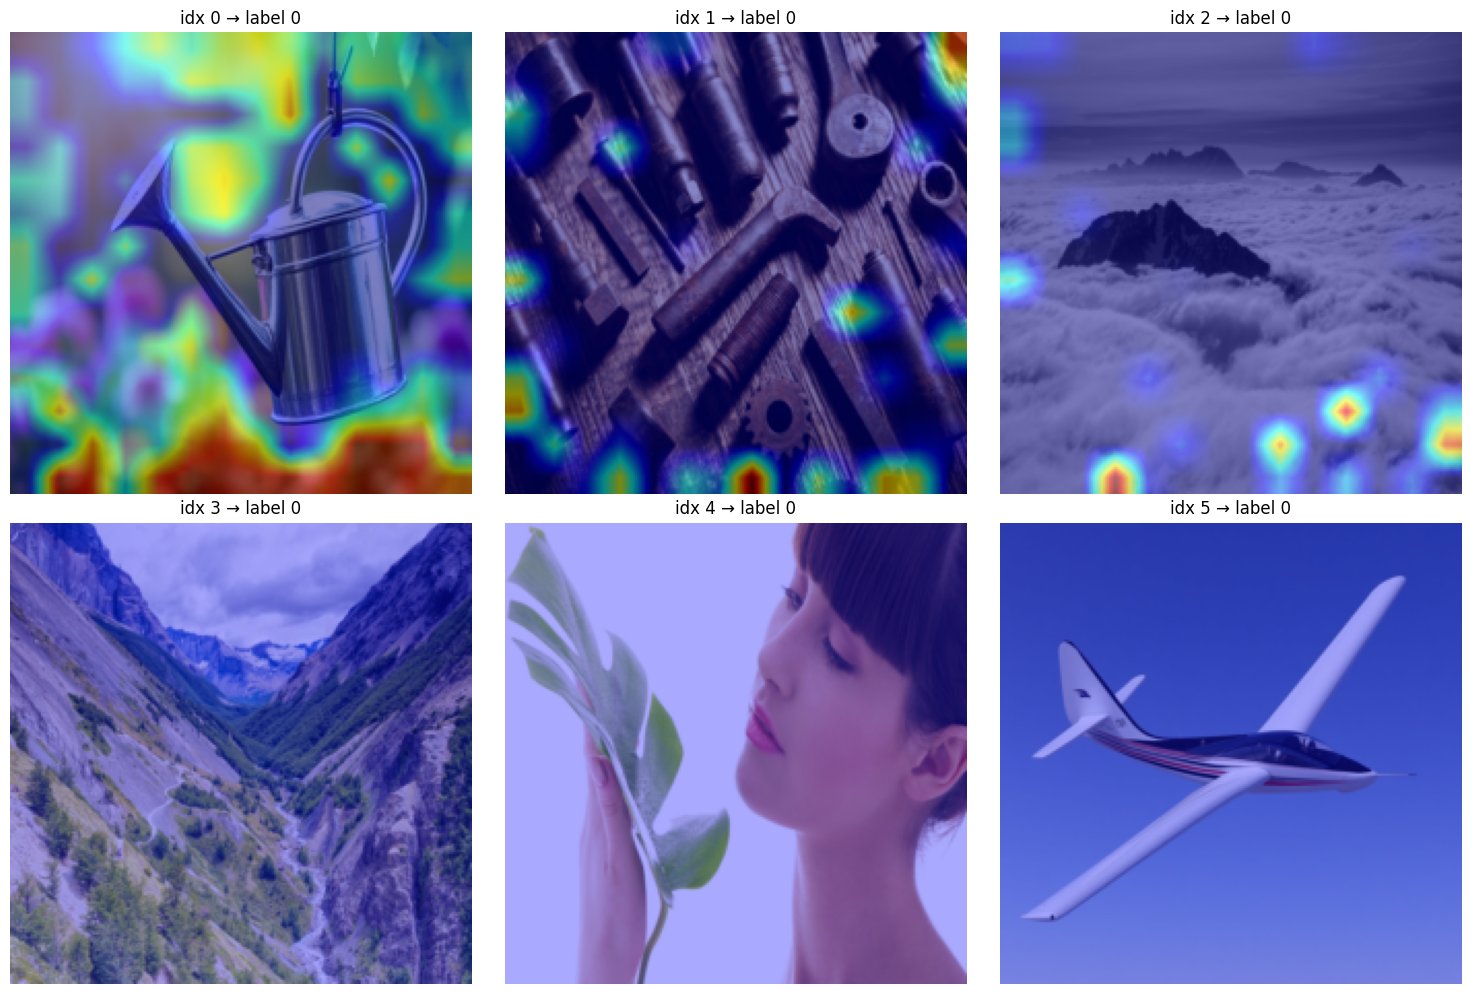

In [8]:
# Grad-CAM for Six Examples
fig, axes = plt.subplots(2, 3, figsize=(15,10))
for ax, idx in zip(axes.flatten(), example_indices):
    img_t = test_dataset[idx]
    rgb_np = img_t.permute(1,2,0).cpu().numpy()
    rgb_vis= (rgb_np * 0.5 + 0.5).clip(0,1)
    with torch.no_grad():
        lbl = model(img_t.unsqueeze(0).to(device)).argmax(1).item()
    heatmap = cam(input_tensor=img_t.unsqueeze(0),
                  targets=[ClassifierOutputTarget(lbl)])[0]
    cam_img = show_cam_on_image(rgb_vis, heatmap, use_rgb=True)
    ax.imshow(cam_img)
    ax.set_title(f"idx {idx} → label {lbl}")
    ax.axis('off')

plt.tight_layout()
plt.show()

LIME Explanation

  0%|          | 0/1000 [00:00<?, ?it/s]

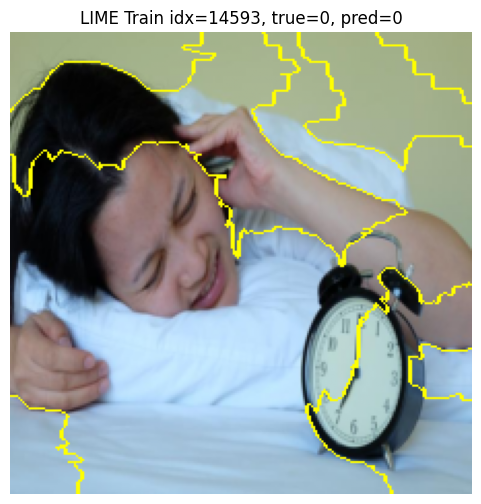

In [9]:
# Convert to uint8 HWC for LIME
image_tensor, true_label = train_dataset[train_first_idx]
rgb_np = image_tensor.permute(1,2,0).cpu().numpy()
rgb_vis = (rgb_np * 0.5 + 0.5).clip(0,1)
rgb_uint8 = (rgb_vis * 255).astype(np.uint8)

# model prediction
with torch.no_grad():
    pred_label = model(image_tensor.unsqueeze(0).to(device)).argmax(1).item()

# LIME prediction wrapper
def predict_fn(images):
    """
    images: list of HWC uint8 arrays
    returns: array shape (N,2) of softmax probabilities
    """
    model.eval()
    batch = []
    for img in images:
        t = TF.to_tensor(Image.fromarray(img))          # HWC uint8 -> CHW float
        t = TF.resize(t, (224,224))
        t = TF.normalize(t, [0.5]*3, [0.5]*3)
        batch.append(t)
    batch = torch.stack(batch).to(device)
    
    with torch.no_grad():
        logits = model(batch)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
    return probs

# Create explainer and run
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    rgb_uint8,
    classifier_fn=predict_fn,
    labels=(true_label,),
    hide_color=0,
    num_samples=1000
)

# Get mask for the predicted label
temp, mask = explanation.get_image_and_mask(
    true_label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Train idx={train_first_idx}, true={true_label}, pred={pred_label}")
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

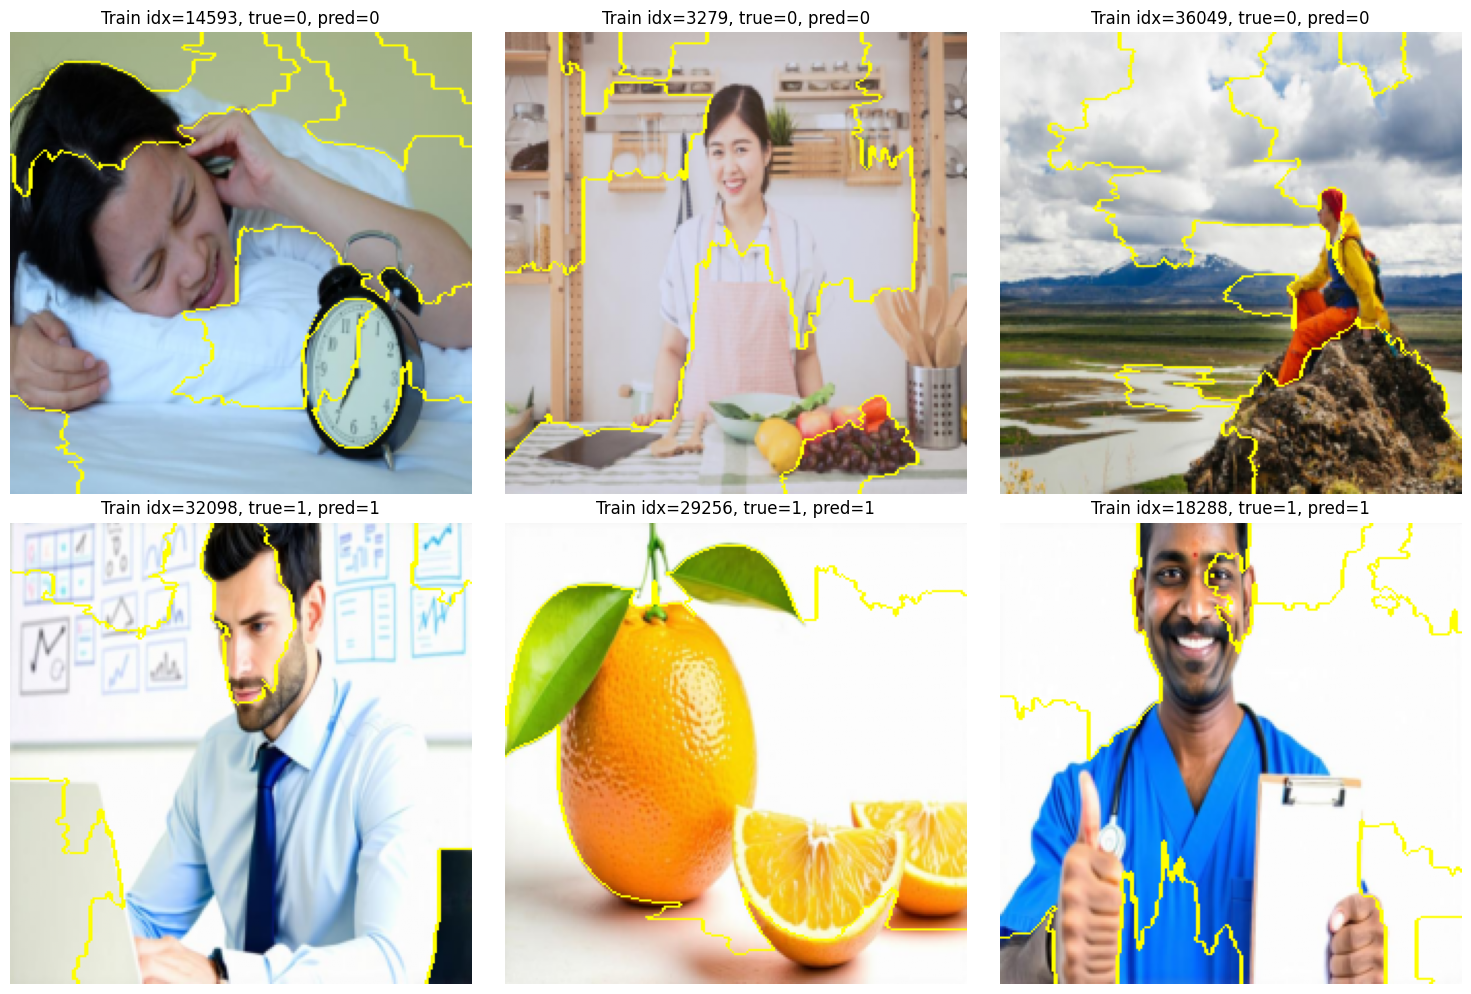

In [10]:
# Six Training Examples: LIME
fig, axes = plt.subplots(2, 3, figsize=(15,10))

for ax, idx in zip(axes.flatten(), train_example_indices):
    img_t, true_label = train_dataset[idx]
    rgb_np    = img_t.permute(1,2,0).cpu().numpy()
    rgb_vis   = (rgb_np * 0.5 + 0.5).clip(0,1)
    rgb_uint8 = (rgb_vis * 255).astype(np.uint8)

    # run LIME for true label
    explanation = explainer.explain_instance(
        rgb_uint8,
        classifier_fn=predict_fn,
        labels=(true_label,),
        hide_color=0,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        true_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # model prediction
    with torch.no_grad():
        pred_label = model(img_t.unsqueeze(0).to(device)).argmax(1).item()

    ax.imshow(mark_boundaries(temp, mask))
    ax.set_title(f"Train idx={idx}, true={true_label}, pred={pred_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

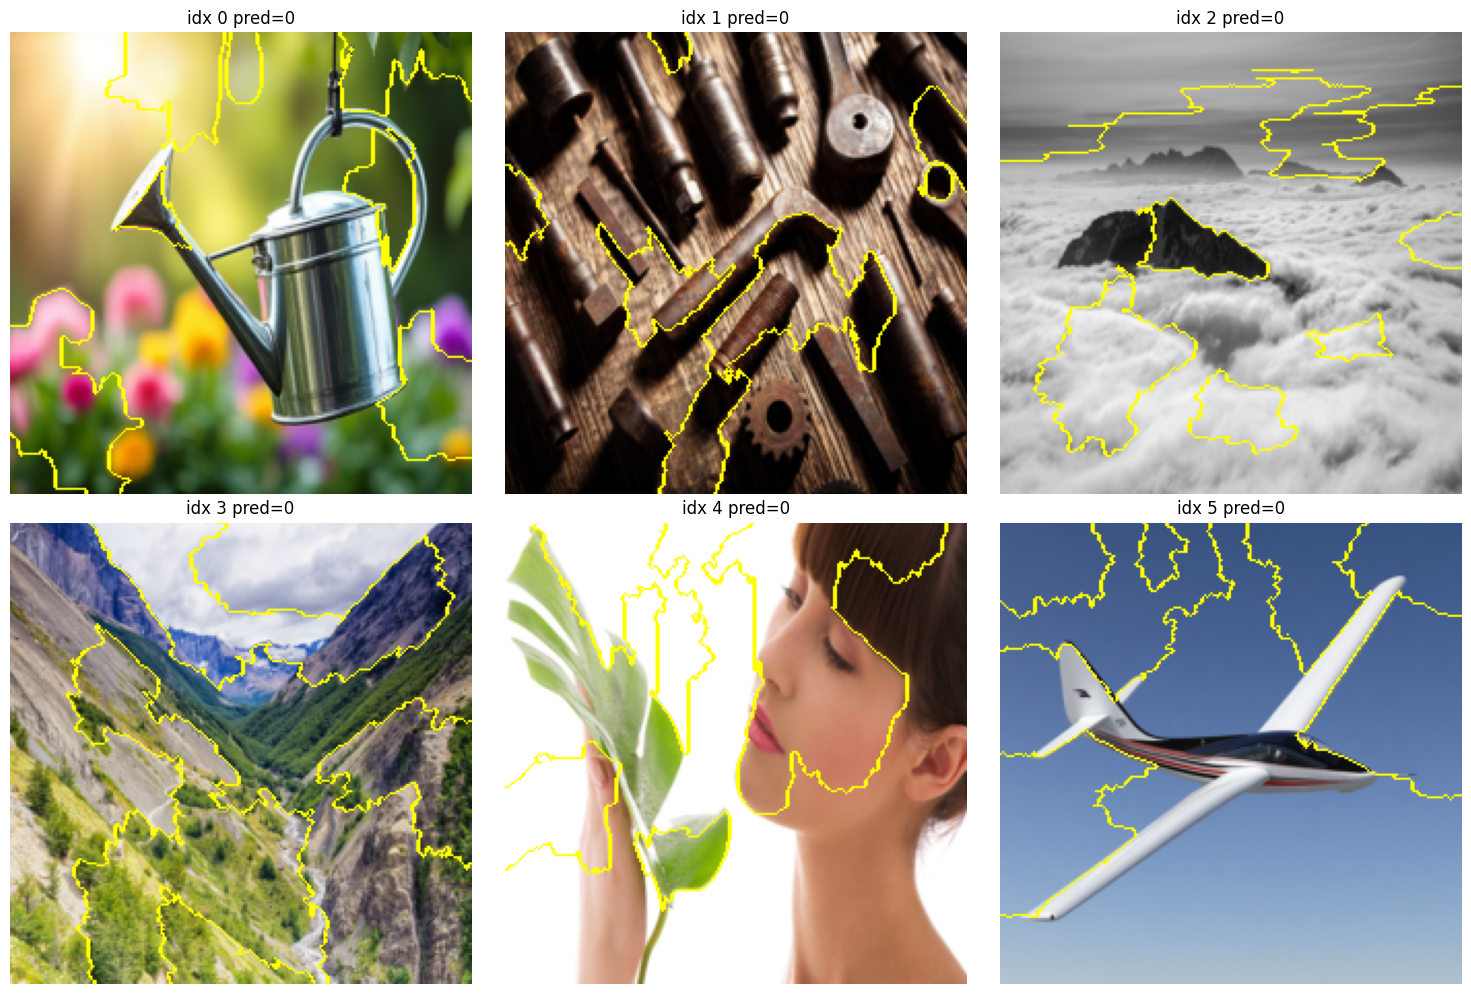

In [11]:
# LIME for Six Test Examples
fig, axes = plt.subplots(2, 3, figsize=(15,10))
for ax, idx in zip(axes.flatten(), example_indices):
    img = test_dataset[idx]
    rgb_np = img.permute(1,2,0).cpu().numpy()
    vis = (rgb_np * 0.5 + 0.5).clip(0,1)
    uint8 = (vis * 255).astype(np.uint8)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()

    exp_i = explainer.explain_instance(
        uint8,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    temp, mask = exp_i.get_image_and_mask(
        pred, positive_only=True, num_features=10, hide_rest=False
    )
    ax.imshow(mark_boundaries(temp, mask))
    ax.set_title(f"idx {idx} pred={pred}")
    ax.axis('off')

plt.tight_layout()
plt.show()